In [3]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import platform
#import SIRD_Model_Experimental
import SIRD_Model
from sklearn import linear_model


# Determining Beta At Time t

# $\beta_{t} = \sigma_{t} \cdot \frac{q \cdot Pop + \tilde I_{C(t)} - \tilde Z_{t}}{\tilde I_{C(t)} (q \cdot Pop - \tilde Z_{t})} \cdot \tilde Z_{t} $ 

In [4]:
def getGamma(infect, dead):
    
    recovG = approxRecovered(infect)
    infect = infect - recovG - dead
    infect = infect[:299].reshape((299,1))
    recovGD = np.diff(recovG)
    recovGD - recovGD.reshape((299,1))

    gamma = np.linalg.lstsq(infect, recovGD)[0]
    return gamma

def approxRecovered(infect):
    recovG = np.zeros(len(infect))
    for i in range(len(infect) - 13):
        recovG[i + 13] = infect[i] - dead[i + 13]
    return recovG


def getBeta(pop, q, infect, dead):
    
    winSize = 13
    sigma = regressionSlopeSeries(infect, winSize )
    recov = approxRecovered(infect)
    infectN = infect - recov - dead
    Z = infect 
    Zt = Z 
    It = infectN 
    halfwin = winSize // 2
    Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) * Zt[halfwin:len(It)-halfwin]
    
    fig,ax = plt.subplots(figsize = (18,8))
    ax.plot(sigma, '.', color = 'red')
    ax.set_title("Sigma (Estimated Derivative) Over Time")
    
    return Beta
    
    
def getRegressionSlope(points):
    """
    Takes a given number of points and outputs slope determined by linear regression
    Times can be included, if they are not, the indexes are assumed to be the times, starting from 0
    """
    timeArray = np.ones((len(points), 2))
    timeArray[:,1]  = np.arange(len(points))
    pointArray = np.array(points)
    point_slope, res, _, _ = np.linalg.lstsq(timeArray, np.log(pointArray), rcond=None)
    slope = point_slope[1]
    return slope

def regressionSlopeSeries(points, window):
    """
    Given a series of points and a window size, estimates the slope at each point
    Outputs both the estimated slopes and regression errors for all applicable points
    If times list is provided, each of the included times should match up respectively with the points
    Window should be odd, if it isn't it will automatically be interpreted as one larger than the argument passed
    """
    # cut the window in half so we know how long it extends on both sides
    half_window = window//2
    num_points = len(points)
    slopes = []

    for i in range(num_points):
        # if there are not enough previous values to satisfy window size, continue
        if i < half_window:
            continue
        # if there are not enough values after the current one to satisfy window size, break
        if num_points-i <= half_window:
            break
        slope = getRegressionSlope(points[i-half_window: i+half_window])
        slopes.append(slope)

    slopes = np.array(slopes)
    return slopes




# Texas

<ipython-input-4-76db8df6c9e1>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  gamma = np.linalg.lstsq(infect, recovGD)[0]


Text(0.5, 1.0, 'Beta over Time')

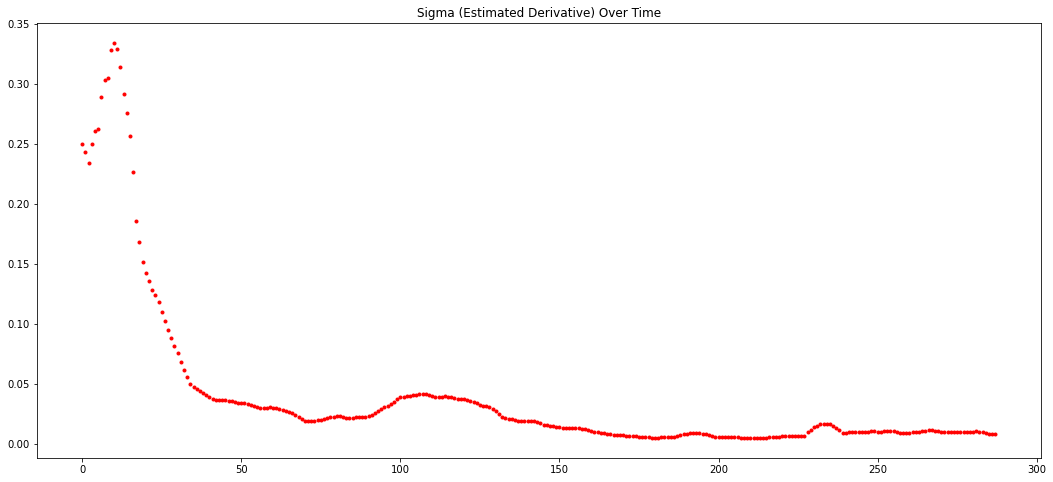

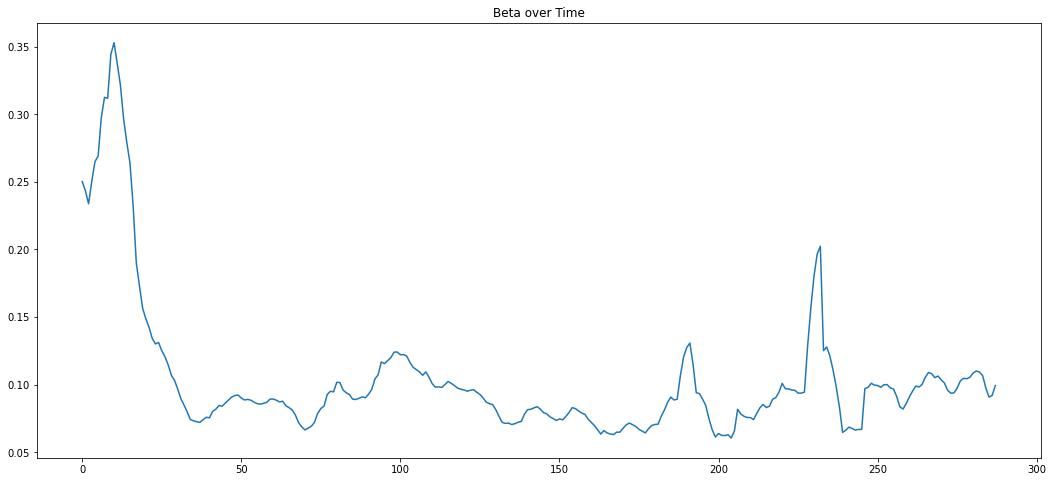

In [5]:
pathc="../Data/Covid Tracking State Data/"
# modify the path syntax based on the current platform
if platform.system() == "Windows":
    pathc.replace("/", "\\")
    
filename = "TX.csv"

dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + filename)

pop = 29000000
numDays = 300
daysToPredict = 30
infect = infectRaw[0:numDays]
dead = deadRaw[0:numDays]

gamma = getGamma(infect,dead)
q = 0.0754
beta = getBeta(pop, q, infect, dead)
#print(gamma, beta)

fig, ax = plt.subplots(figsize = (18,8))
ax.plot(beta)
ax.set_title("Beta over Time")
#plt.yscale("log")

# Texas starting 30 days in the future

<ipython-input-4-76db8df6c9e1>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  gamma = np.linalg.lstsq(infect, recovGD)[0]


Text(0.5, 1.0, 'Beta over Time')

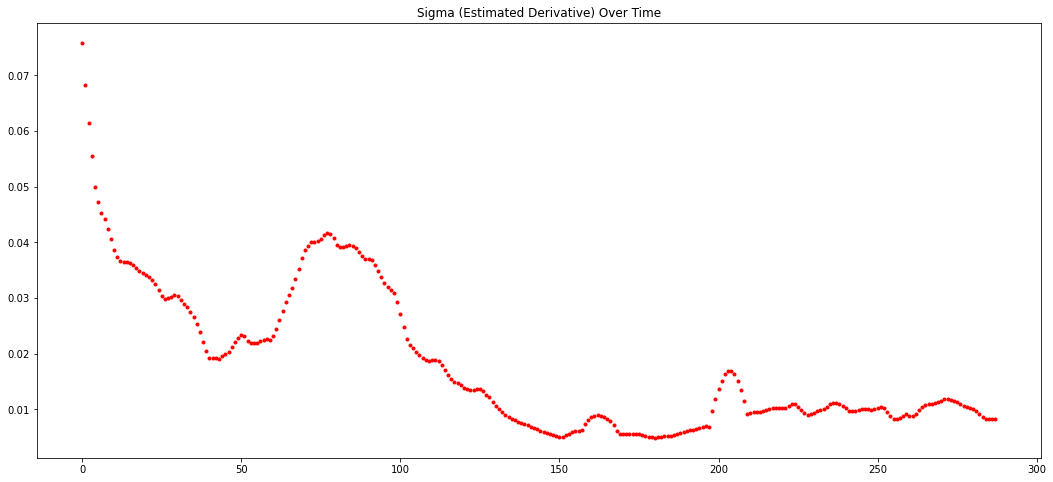

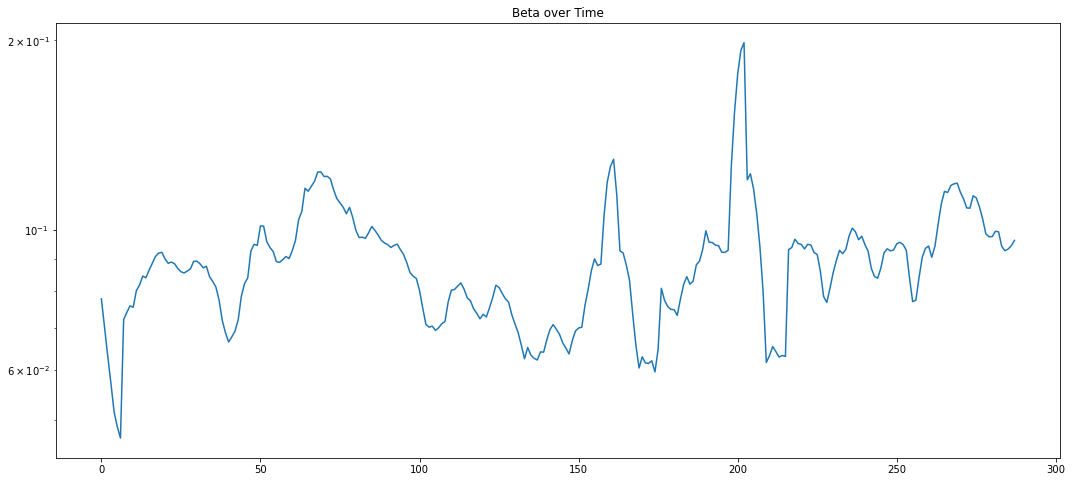

In [6]:
pathc="../Data/Covid Tracking State Data/"
# modify the path syntax based on the current platform
if platform.system() == "Windows":
    pathc.replace("/", "\\")
    
filename = "TX.csv"

dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + filename)

pop = 29000000
numDays = 330
daysToPredict = 30
infect = infectRaw[30:numDays]
dead = deadRaw[30:numDays]

gamma = getGamma(infect,dead)
q = 0.1
beta = getBeta(pop, q, infect, dead)
#print(gamma, beta)

fig, ax = plt.subplots(figsize = (18,8))
ax.plot(beta)
plt.yscale("log")
ax.set_title("Beta over Time")

# New York

<ipython-input-4-76db8df6c9e1>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  gamma = np.linalg.lstsq(infect, recovGD)[0]


Text(0.5, 1.0, 'Beta over Time')

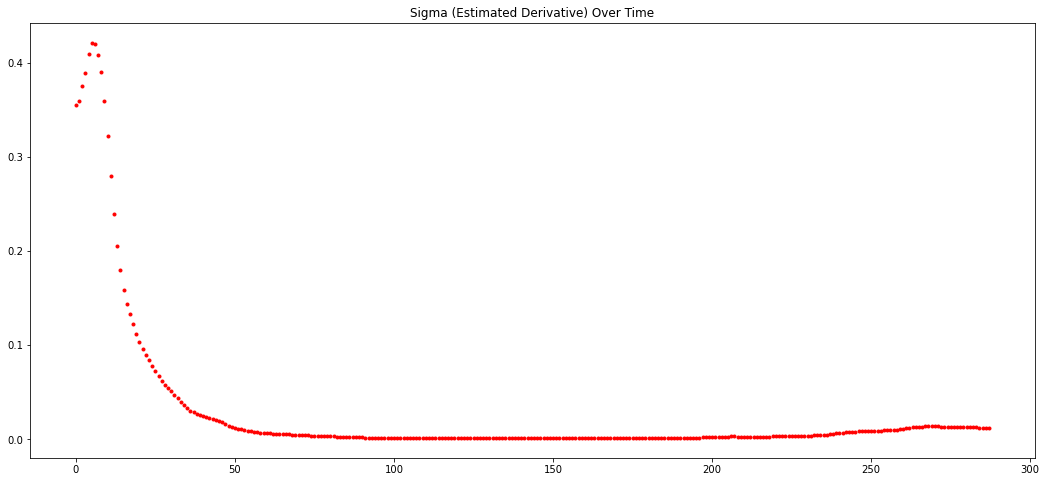

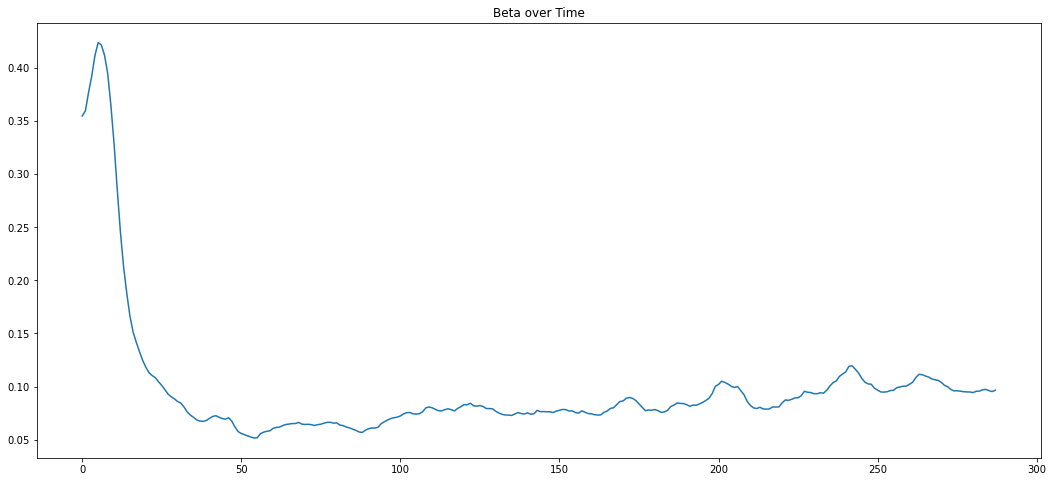

In [7]:
pathc="../Data/Covid Tracking State Data/"
# modify the path syntax based on the current platform
if platform.system() == "Windows":
    pathc.replace("/", "\\")
    
filename = "NY.csv"

dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + filename)

pop = 20201249
numDays = 300
daysToPredict = 30
infect = infectRaw[0:numDays]
dead = deadRaw[0:numDays]

gamma = getGamma(infect,dead)
q = .0754
beta = getBeta(pop, q, infect, dead)
#print(gamma, beta)

fig, ax = plt.subplots(figsize = (18,8))
ax.plot(beta)
ax.set_title("Beta over Time")
#plt.yscale("log")

# CA

<ipython-input-4-76db8df6c9e1>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  gamma = np.linalg.lstsq(infect, recovGD)[0]


Text(0.5, 1.0, 'Beta over Time')

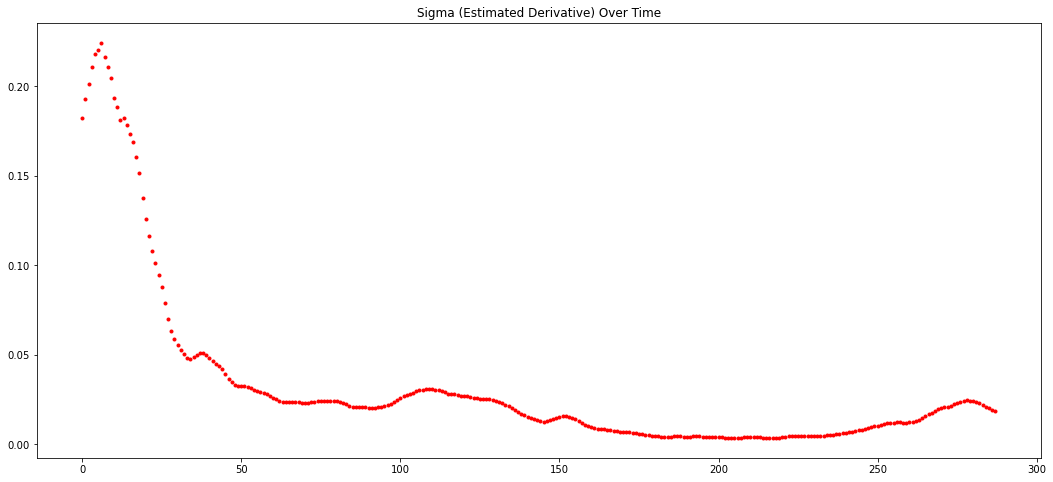

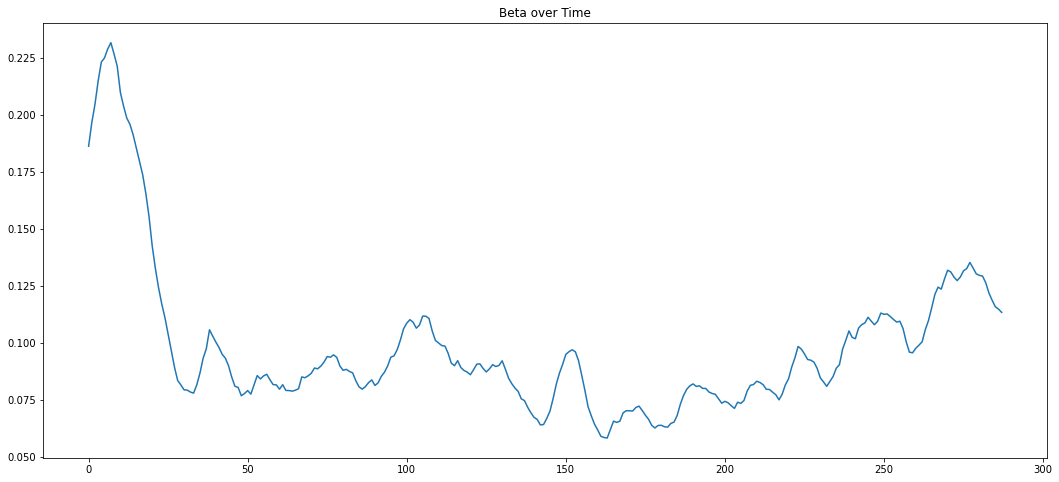

In [8]:
pathc="../Data/Covid Tracking State Data/"
# modify the path syntax based on the current platform
if platform.system() == "Windows":
    pathc.replace("/", "\\")
    
filename = "CA.csv"

dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + filename)

pop = 39510000
numDays = 300
daysToPredict = 30
infect = infectRaw[0:numDays]
dead = deadRaw[0:numDays]

gamma = getGamma(infect,dead)
q = .0754
beta = getBeta(pop, q, infect, dead)
#print(gamma, beta)

fig, ax = plt.subplots(figsize = (18,8))
ax.plot(beta)
ax.set_title("Beta over Time")
#plt.yscale("log")

# Florida

<ipython-input-4-76db8df6c9e1>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  gamma = np.linalg.lstsq(infect, recovGD)[0]


Text(0.5, 1.0, 'Beta over Time')

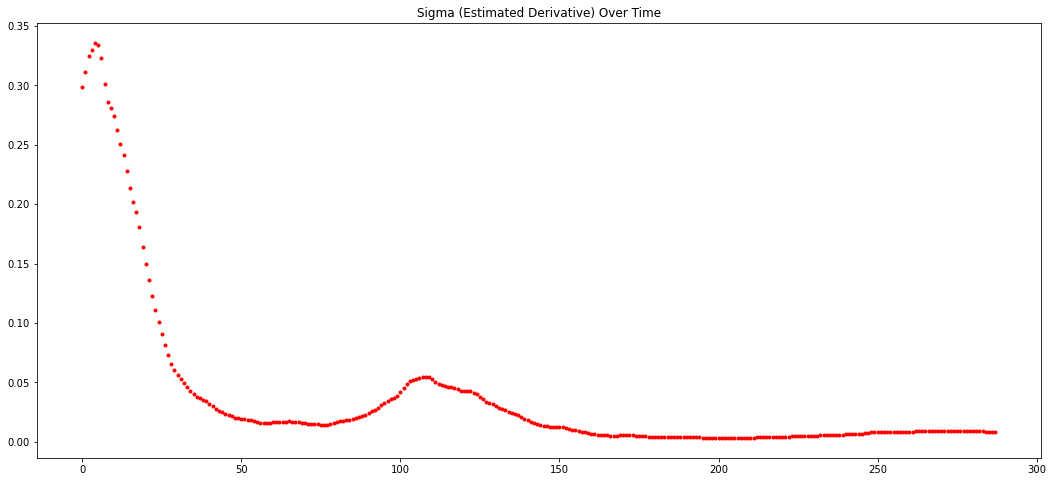

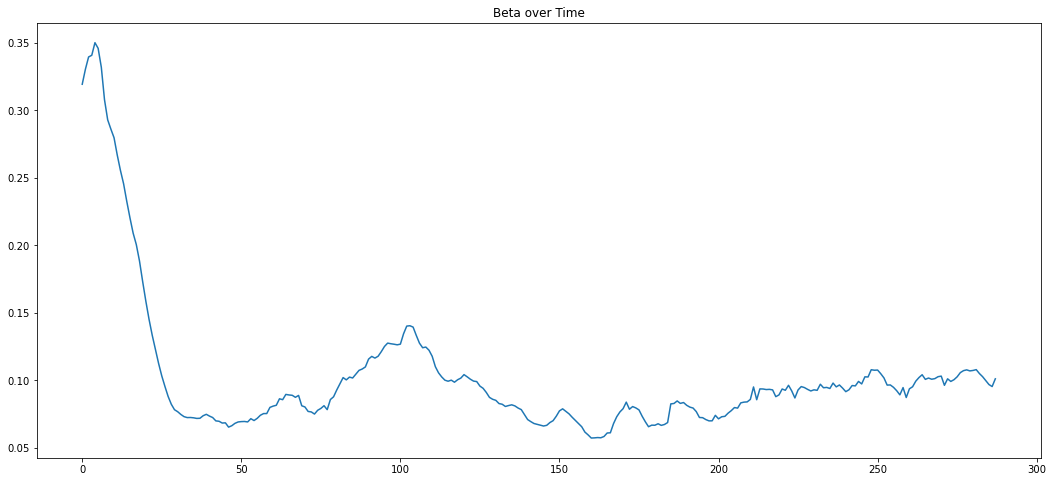

In [9]:
pathc="../Data/Covid Tracking State Data/"
# modify the path syntax based on the current platform
if platform.system() == "Windows":
    pathc.replace("/", "\\")
    
filename = "FL.csv"

dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + filename)

pop = 21480000
numDays = 300
daysToPredict = 30
infect = infectRaw[0:numDays]
dead = deadRaw[0:numDays]

gamma = getGamma(infect,dead)
q = 0.0754
beta = getBeta(pop, q, infect, dead)
#print(gamma, beta)

fig, ax = plt.subplots(figsize = (18,8))
ax.plot(beta)
ax.set_title("Beta over Time")
#plt.yscale("log")


# Arizona

<ipython-input-4-76db8df6c9e1>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  gamma = np.linalg.lstsq(infect, recovGD)[0]


Text(0.5, 1.0, 'Beta over Time')

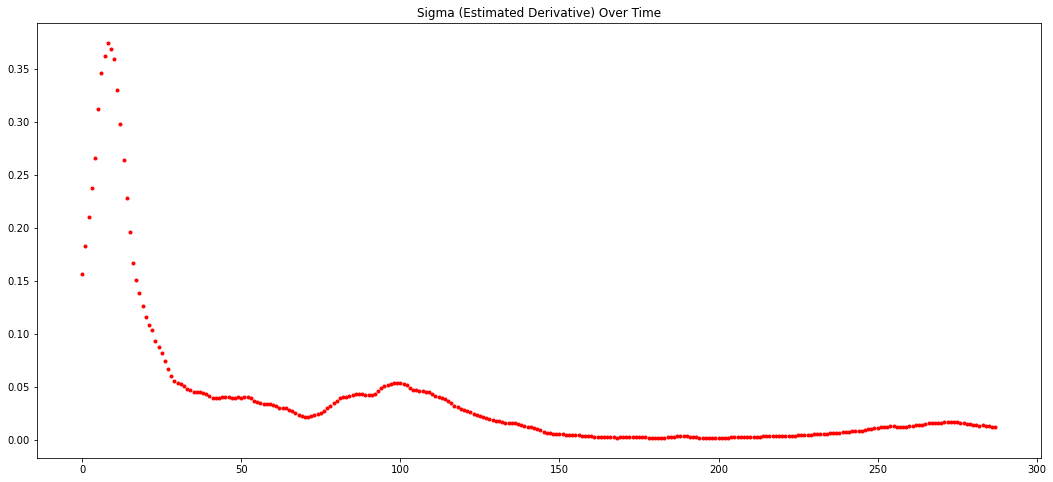

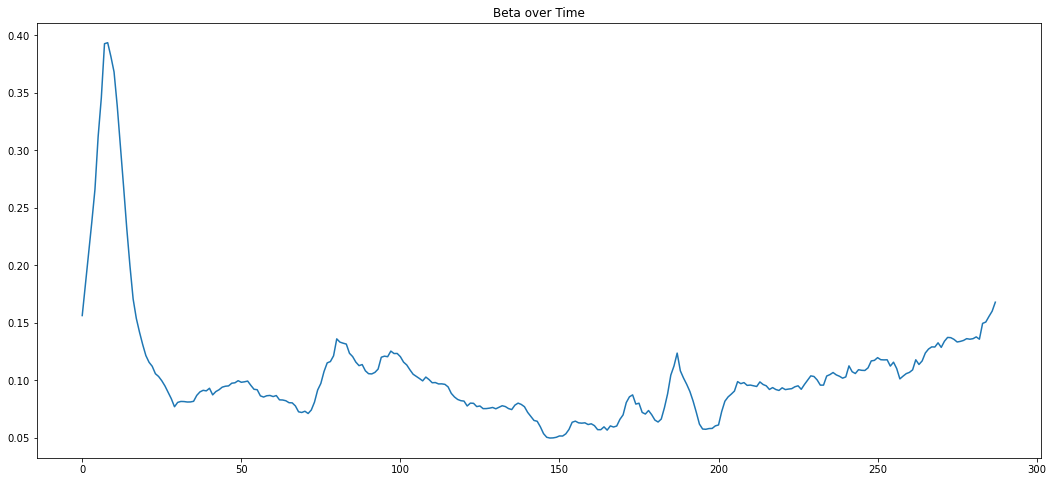

In [10]:
pathc="../Data/Covid Tracking State Data/"
# modify the path syntax based on the current platform
if platform.system() == "Windows":
    pathc.replace("/", "\\")
    
filename = "AZ.csv"

dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + filename)

pop = 7279000
numDays = 300
daysToPredict = 30
infect = infectRaw[0:numDays]
dead = deadRaw[0:numDays]

gamma = getGamma(infect,dead)
q = 0.0754
beta = getBeta(pop, q, infect, dead)
#print(gamma, beta)

fig, ax = plt.subplots(figsize = (18,8))
ax.plot(beta)
#ax.set_ylim([0,0.0001])
ax.set_title("Beta over Time")
#plt.yscale("log")